In [1]:
# imported dependencies
import pennylane as qml
from itertools import product
import numpy as np
import random

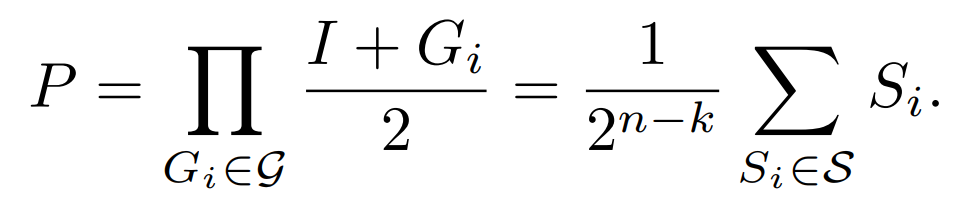

In [2]:
G1 = qml.Identity(0) @ qml.PauliZ(1) @ qml.PauliZ(2)
G2 = qml.PauliZ(0) @ qml.PauliZ(1) @ qml.Identity(2)

G1 = G1.matrix()
G2 = G2.matrix()

# S size of 4 (Assuming generators that we chose should be able to make up the set of S)
I = qml.Identity(0) @ qml.Identity(1) @ qml.Identity(2)
I = I.matrix()

G = [G1, G2]
S = [G1, G2, G1 @ G2, I]


# Assume all G are same size
def calculate_P_with_G(G):
    # G1 and G2 are diagonal matrix so the eigenvalues are just the values of the diagonal
    # Furthermore, the values are only +/- 1
    # If we add the identity matrix then the eigenvalues become 0 and 2
    # If we divide by 2 all eigenvalues become only 0 or 1
    I = np.eye(G[0].shape[0])
    P = np.eye(G[0].shape[0])
    for g in G:
        P = P @ (I + g)/2
    return P

def calculate_P_with_S(S):
    P = np.zeros(S[0].shape)
    for elem in S:
        P += elem
    # Same reasoning above, have to divide to get eigenvalue back to 0 or 1 
    P *= 1/(len(S))
    return P
        
P1 = calculate_P_with_G(G)
P2 = calculate_P_with_S(S)
P = P1

In [3]:
# generate the density matrix
def generate_density_matrix():
    state = np.array([0.5, 0.5, 0, 0.5,0,0,0.5,0])
    rho = np.outer(state, np.conj(state).T)
    return rho


In [4]:

dev = qml.device("default.mixed", wires=3)

@qml.qnode(dev)
def generate_noise(wires):
    density_matrix = generate_density_matrix()
    qml.QubitDensityMatrix(density_matrix, wires=wires)
    qml.BitFlip(0.75,wires[0])
    qml.BitFlip(0.35,wires[1])
    qml.BitFlip(1,wires[2])
    return qml.density_matrix(wires)


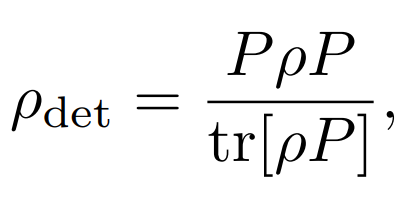

In [5]:
# create rho with noise applied
rho =  generate_noise([0,1,2])
rho_det = (P @ rho @ P)/np.trace(rho @ P)


In [6]:
# Create observable O
O = qml.Identity(0) @ qml.Identity(1) @ qml.PauliZ(2)
O = O.matrix()


# Expected value of the observable 
expected = np.trace(rho_det @ O)
print(expected)

(-0.25925925925925336+0j)


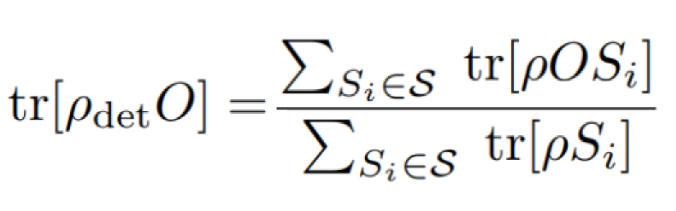

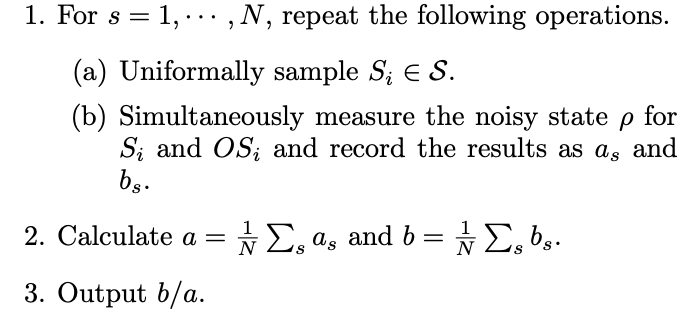

In [7]:
N = 50000
a = 0
b = 0

for i in range(N):
    Si = random.sample(S,1)[0]
    a_s = np.trace(rho @ Si)
    b_s = np.trace(rho @ O @ Si)
    a += a_s
    b += b_s
actual = b/a
print("Expected: " + str(expected))
print("Actual: " + str(actual))
print("Error: " + str(abs((actual-expected)/expected)*100))

Expected: (-0.25925925925925336+0j)
Actual: (-0.2568614722411644+0j)
Error: 0.9248607069771909


In [8]:
# Compute tr[p_det @ O]
num = np.trace(rho @ O @ P)
denom = np.trace(rho @ P)
print("tr[pOP]")
print(num)
print("tr[pP]")
print(denom)
print("tr[pOP] / tr[pP]")
print(num/denom)


tr[pOP]
(-0.043750000000002454+0j)
tr[pP]
(0.1687500000000133+0j)
tr[pOP] / tr[pP]
(-0.25925925925925336+0j)
